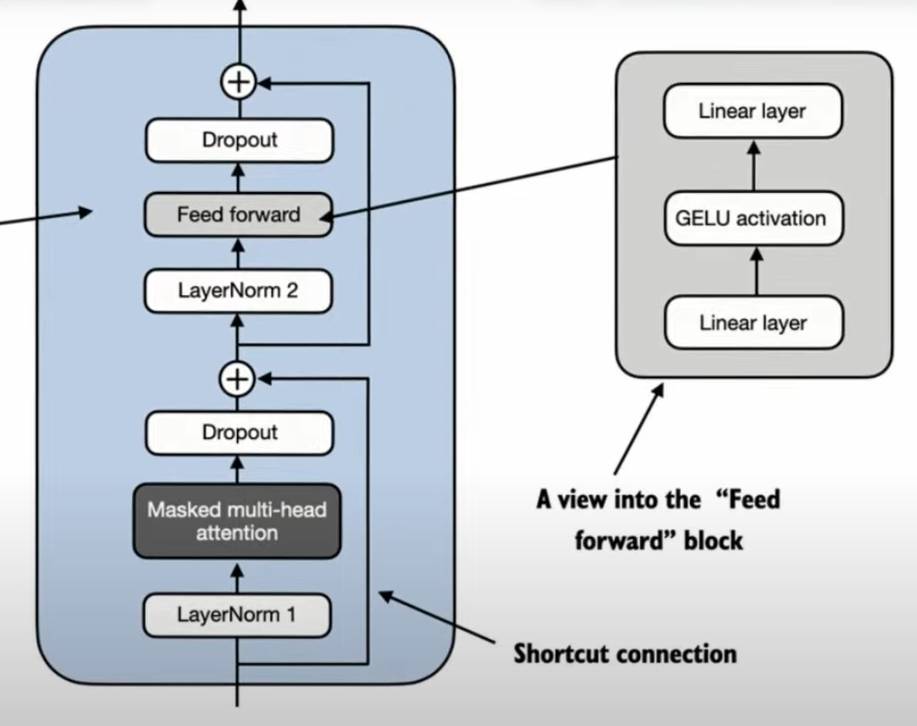

# Imports

In [3]:
import os
import random

import torch

In [10]:
torch.manual_seed(123)

# gpt metadata

In [22]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

# Implementing layer normalization:

we normalize the data, ie mean = 0 and varience = 1

in batch normalization, we normalize the values across batches, in layer norm we normalize the values in 1 input row.

normalization is done by subtracting the mean from every input value, and dividing it by the varience.

out_morm = out - mean / var

In [11]:
batch_example = torch.randn(2, 5) #A
layer = torch.nn.Sequential(torch.nn.Linear(5, 6), torch.nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


in layer norm we calc mean by summing the values in the row, ie 0.2260 + 0.3470 + 0.0000 + 0.2216 + 0.0000 + 0.0000 / 6

In [12]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(mean)
print(var)

tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [13]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


we add trainable weights scale and shift along with the normalization done by subtracting mean and dividing by variance

In [17]:
class LayerNorm(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = torch.nn.Parameter(torch.ones(emb_dim))
        self.shift = torch.nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [18]:
ln = LayerNorm(5)
out_ln = ln(batch_example)
print(out_ln)

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)


## Batch normalization

in batch normalization, we normalize the values across a batch.

ie in above eg we calculate mean along the column instead of the row

In [14]:
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [16]:
batch_morm_out = (out - out.mean(dim=0, keepdim=True)) / torch.sqrt(out.var(dim=0, keepdim=True))
print(batch_morm_out)

tensor([[ 0.7071,  0.7071,     nan, -0.7071, -0.7071,     nan],
        [-0.7071, -0.7071,     nan,  0.7071,  0.7071,     nan]],
       grad_fn=<DivBackward0>)


# GELU activation

gaussian error linear unit

$$GELU_{\tanh}(x) = 0.5x \left(1 +
 tanh\left(\sqrt{\frac{2}{\pi}}\left(x + 0.044715x^3\right)\right)\right)$$

 it acts as relu for larger values of x, for smaller values of x, it is close to 0 not exactly 0. hence it does not completly disregard the values when they are less than 0 like relu.

In [20]:
class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

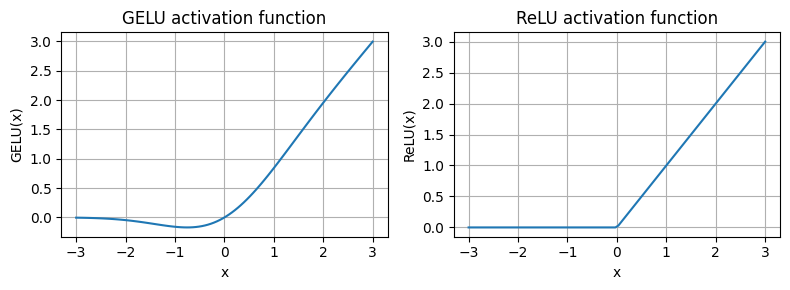

In [21]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), torch.nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


# Feed forward layer

the feed forward network is a expansion contraction neural network.

its first layer has 4 * embedding_dim neurons, then we have GELU activation and the last layer has embedding_dim num of neurons.

the input to this feed forward layer is the output of multihead layer and the residual connection of the input. hence the dimension of input are (batch, context_length, embedding_dim)

the output of the feed forward network is also (batch, context_length, embedding_dim) cause we expand is first, but then contract by the same amount

In [26]:
class FeedForward(torch.nn.Module):
    def __init__(self, config): ## config is a dictionary that contains the metadata of the gpt2 model
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
            GELU(),
            torch.nn.Linear(4 * config["emb_dim"], config["emb_dim"])
        )

    def forward(self, x):
      return self.layers(x)

In [28]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
out


tensor([[[-0.1005,  0.0791,  0.0730,  ...,  0.1855, -0.0125,  0.1420],
         [-0.0479,  0.1470,  0.1014,  ...,  0.1122,  0.0202,  0.1237],
         [-0.0620,  0.0406,  0.0486,  ...,  0.1677, -0.0058,  0.0391]],

        [[-0.0405,  0.1374,  0.0671,  ...,  0.0965,  0.0125,  0.0526],
         [-0.0375, -0.0628, -0.0132,  ...,  0.0577, -0.0398,  0.0773],
         [ 0.0552,  0.0462,  0.0352,  ...,  0.1805, -0.1117,  0.2043]]],
       grad_fn=<ViewBackward0>)

In [29]:
print(out.shape)

torch.Size([2, 3, 768])


# multi head attention

done in attention notebook in detail

In [30]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, embedding_dim, context_length, num_heads,final_out_dim, dropout, qkv_bias=False):
        super().__init__()
        assert (final_out_dim % num_heads == 0), \
            "final_out_dim must be divisible by num_heads"

        self.final_out_dim =final_out_dim
        self.num_heads = num_heads
        self.head_dim =final_out_dim // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = torch.nn.Linear(embedding_dim,final_out_dim, bias=qkv_bias)
        self.W_key = torch.nn.Linear(embedding_dim,final_out_dim, bias=qkv_bias)
        self.W_value = torch.nn.Linear(embedding_dim,final_out_dim, bias=qkv_bias)

        self.out_proj = torch.nn.Linear(final_out_dim,final_out_dim)  # Linear layer to combine head outputs

        self.dropout = torch.nn.Dropout(dropout)

        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, embedding_dim = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens,final_out_dim)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens,final_out_dim) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        # attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = torch.softmax(attn_scores / self.head_dim**0.5, dim=-1)

        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.final_out_dim)

        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

# final Transformer block

In [31]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            embedding_dim = cfg["emb_dim"],
            final_out_dim = cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"])

        self.ff = FeedForward(cfg)

        self.norm1 = LayerNorm(cfg["emb_dim"])

        self.norm2 = LayerNorm(cfg["emb_dim"])

        self.drop_shortcut = torch.nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        residual_conn1 = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + residual_conn1  # Add the original input back

        # Shortcut connection for feed forward block
        residual_conn_2 = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + residual_conn_2  # Add the original input back

        return x
        # 2*4*768

In [32]:
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
